## Libraries and constants

In [16]:
# Load project functions
import crypto_monetary_base as cmb

In [17]:
import pandas as pd
import datetime, math
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [5]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 2 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Sat Feb 13 20:45:24 2021 EST

## Starting simple

Let's start with what Bitcoin did: halving every ~4 years, 99+% of issuance within 30 years, 21M coins total. Bitcoin supply doesn't fully taper off until 2140 but it flattens out by about 2040. Let's analyze it from genesis through the next 30 years, to about 2050.

In [22]:
def btc_block_supply_curve():
    out = [
        # Block num,
        # Total supply,
    ]
    inflation_change_blocks = 210_000
    inflation_change_frac = 0.5
    y = 0
    block = 0
    while block < 2_200_000:
        block += 1
        num_changes = int(
            (block - 1) / inflation_change_blocks
        )
        block_reward = 50 * (
            inflation_change_frac ** num_changes
        )
        y += block_reward
        out.append([block, y])

    return out

In [23]:
start_date = datetime.date(2009, 1, 3)
block_time = datetime.timedelta(seconds=60 * 10)

block_supply = btc_block_supply_curve()

supply = cmb.datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

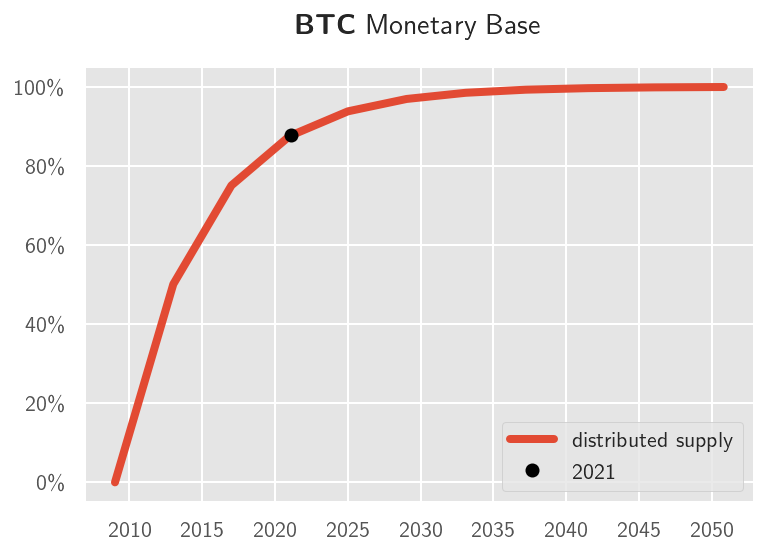

In [24]:
cmb.plot_supply_curve(
    supply,
    'BTC',
);

## Smoothing out the curve

The first and most obvious improvement we can make is to smooth out the curve by replacing periodic halvenings with an exponential decay function. We'll set the half life to 210,000 blocks (~4 years) to match the original curve.

In [25]:
def btc_block_supply_curve_smooth():
    out = [
        # Block num,
        # Total supply,
    ]
    half_life_blocks = 210_000
    tot_supply = 21_000_000
    btc_lambda = math.log(2)/half_life_blocks
    block = 0
    while block < 2_200_000:
        block += 1
        y = tot_supply * (1 - (math.exp(-1 * btc_lambda * block)))
        out.append([block, y])

    return out

In [26]:
block_supply = btc_block_supply_curve_smooth()

supply = cmb.datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

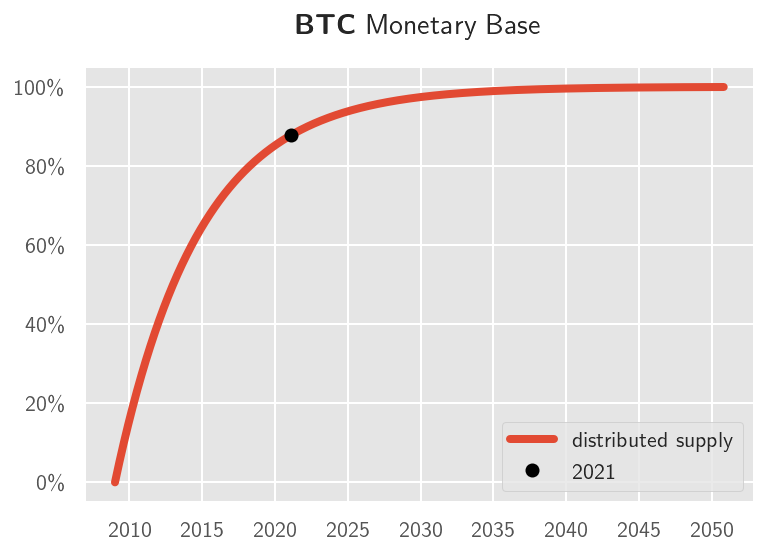

In [27]:
cmb.plot_supply_curve(
    supply,
    'BTC',
);

## Changing the shape of the curve

If we felt that BTC issuance occurred too quickly, we could change the shape of the curve by changing the half-life. Let's see what it would look like with a 6, 8, and 10-year half-life (rather than 4).

In [42]:
def btc_block_supply_curve_smooth():
    out = [
        # Block num,
        # Total supply (4 year half-life),
        # Total supply (6 year half-life),
        # Total supply (8 year half-life),
        # Total supply (10 year half-life),
    ]
    tot_supply = 21_000_000
    btc_lambda_1 = math.log(2)/210_000
    btc_lambda_2 = math.log(2)/315_000
    btc_lambda_3 = math.log(2)/420_000
    btc_lambda_4 = math.log(2)/525_000
    block = 0
    while block < 2_200_000:
        block += 1
        y_1 = tot_supply * (1 - (math.exp(-1 * btc_lambda_1 * block)))
        y_2 = tot_supply * (1 - (math.exp(-1 * btc_lambda_2 * block)))
        y_3 = tot_supply * (1 - (math.exp(-1 * btc_lambda_3 * block)))
        y_4 = tot_supply * (1 - (math.exp(-1 * btc_lambda_4 * block)))
        out.append([block, y_1, y_2, y_3, y_4])

    return out

In [31]:
def datetime_supply_curve(
    start_date,
    block_time,
    block_supply,
    ):
    df = pd.DataFrame(
        block_supply, columns=['block', 'total_supply_1', 'total_supply_2', 'total_supply_3', 'total_supply_4']
    )
    df['total_supply_1_pct'] = (
        df['total_supply_1'] / df['total_supply_1'].values[-1]
        * 100
    )
    df['total_supply_2_pct'] = (
        df['total_supply_2'] / df['total_supply_2'].values[-1]
        * 100
    )
    df['total_supply_3_pct'] = (
        df['total_supply_3'] / df['total_supply_3'].values[-1]
        * 100
    )
    df['total_supply_4_pct'] = (
        df['total_supply_4'] / df['total_supply_4'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=block_time,
        periods=len(df)
    )
    return df

In [36]:
def plot_supply_curve(
    supply,
    coin_name,
    plot_pct=True,
    max_size=10000,
    fmt='-',
    out_name='',
    ylim=None,
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])

    if plot_pct:
        values = supply.total_supply_1_pct.values[::step_size]
    else:
        values = supply.total_supply_1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='4 year',
    )

    if plot_pct:
        values = supply.total_supply_2_pct.values[::step_size]
    else:
        values = supply.total_supply_2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='6 year',
    )

    if plot_pct:
        values = supply.total_supply_3_pct.values[::step_size]
    else:
        values = supply.total_supply_3.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='8 year',
    )

    
    if plot_pct:
        values = supply.total_supply_4_pct.values[::step_size]
    else:
        values = supply.total_supply_4.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt=fmt,
        lw=4,
        label='10 year',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.total_supply_1_pct]
    else:
        values = [current_supply.total_supply_1]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.title(
        r'$\textbf{{{}}}$ Monetary Base'.format(coin_name),
        y=1.05
    )
    plt.legend(loc='lower right')
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    return plt

In [43]:
block_supply = btc_block_supply_curve_smooth()

supply = datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

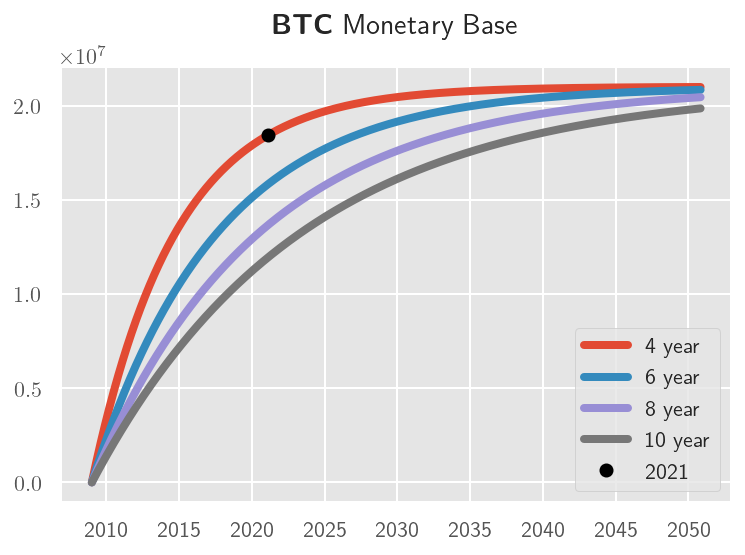

In [44]:
plot_supply_curve(
    supply,
    'BTC',
    plot_pct=False,
);

As the half-life grows, the curve looks more and more linear. It's interesting to note that, due to the logarithmic nature of the curve, even if we more than double the half-life, all the curves still more or less converge at the same point around 2050. We'd have to increase the half-life significantly to extend issuance much further than this.

## Splitting issuance in two

Bitcoin issuance is fixed and has nothing to do with network state, level of security, or network utility. However, we might want to make issuance in Spacemesh contingent upon the amount of spacetime resources committed to the network, at least partially. This directly represents the level of network security and also serves as a reasonable proxy for network utility, as well as overall growth and degree of interest in the project and its ecosystem. Put another way, we may want to defer issuing a portion of coins until the network has achieved certain milestones with respect to maturity. This ensures that it would be attractive for more smeshers to join for a long time after genesis, at least until some minimum desired degree of security or maturity is achieved.

Filecoin introduced this concept and called it ["baseline minting"](https://filecoin.io/blog/filecoin-circulating-supply/) (as opposed to "simple minting", which is fixed regardless of network state, like Bitcoin issuance). The idea is that issuance will be relatively low in the earliest phases of the network, then will increase rapidly as the amount of spacetime committed to the network grows, then will eventually flatten out towards an asymptotic point of maximum issuance (as in Bitcoin).

![Three phases of the Filecoin network](../static/filecoin.png "Filecoin Issuance Model")

### Baseline vs. simple issuance

Here's what the breakdown between simple and baseline issuance looks like in Filecoin, assuming that baseline issuance remains at 70% of total issuance ($\gamma = 0.7$), and that the network achieves its full baseline utilization target. Note that Filecoin issuance uses an exponential decay function (like the second BTC graph above) with a six year half-life.

![Simple vs. baseline issuance in Filecoin](../charts/FIL_simple.png)

### Balancing the two: introducing gamma

The ratio between simple and baseline issuance is set by a parameter called $\gamma$ (gamma). $\gamma$ was set at 0.7 (i.e., 70% contribution from baseline issuance, 30% from simple issuance) for genesis, but it can be moved in the future through governance. This graph shows the effect of gradually increasing $\gamma$ from 0.7 to 1.0, i.e., towards 100% baseline issuance. Note that this causes maximum issuance to be hit fairly quickly.

![The effects of moving gamma](../charts/FIL_complex1.png)

### Effective network time: introducing theta

The purpose of baseline issuance is to set an ever-increasing target for total realized spacetime, and to reduce baseline issuance proportional to how much of that target has been achieved. The above calculations assume that the full target is achieved. In order to calculate how close the network is to its target, Filecoin first calculates cumulative realized network power, a.k.a. "cumulative capped raw-byte power", i.e., realized spacetime, $\overline{R}_\Sigma(t)$. It uses this value to calculate an "effective network time", $\theta(t)$, defined as the solution to the equation

$$\int_0^{\theta(t)} b(x)\space{d}x = \int_0^t \overline{R}(x)\space{d}x = \overline{R}_\Sigma(t)$$

(Full math [here](https://spec.filecoin.io/#section-systems.filecoin_token.block_reward_minting.baseline-minting).)

If the network has achieved 100% target power, effective network time equals current, actual time.

In order to see the effect that $\theta$ has on baseline and total issuance, we can perform a Gaussian random walk on $\theta$ over time using some simple parameters:

This produces the following curve. Even starting at only 20% of the initial baseline target power, with power growing at only 50% of the target growth rate, due to the exponential decay in issuance, total issuance nearly catches up with the 100% baseline after 50 years.

![The effects of varying theta](../charts/FIL_complex2.png)

## Supply Curve Calculation

Given this context, and using a similar approach to Filecoin, what would the SMH issuance curve look like? Let's start with the two [existing, concrete proposals](https://docs.google.com/spreadsheets/d/1jFbyUpsYkwQT-3LPS3L3jBY0Pd26Vkvad6dzNoXHT4Y/edit#gid=1310491469). These proposals entail issuing 4.5M coins over 10 years and 30 years, respectively.

### Some constants

In [58]:
COIN_SYMBOL = 'SMH'
LAYER_TIME = 5 # in minutes
LAYERS_PER_YEAR = 365.25 * 24 * 60 / LAYER_TIME
TOTAL_SUPPLY = 6_000_000
VAULTED_AMOUNT = 1_500_000
TOTAL_ISSUANCE = TOTAL_SUPPLY - VAULTED_AMOUNT

# For exponential decay calculation
HALF_LIFE_LAYERS = LAYERS_PER_YEAR * 6
SMH_LAMBDA = math.log(2)/HALF_LIFE_LAYERS

"""
`year` is zero-indexed
"""
def yearly_issuance(plan, year):
    ## PLAN 1
    # Aviv's first proposal: ten year issuance, gradually decreasing
    if plan == 1:
        if year >= 10:
            return 0
        slots = sum(x for x in range(1, 11))
        per_slot = TOTAL_ISSUANCE / slots
        return per_slot * (10 - year)

    ## PLAN 2
    # Aviv's second proposal: decreasing issuance each year for first ten years,
    # then minor issuance each year for the next twenty years
    elif plan == 2:
        if year >= 30:
            return 0
        # first ten years, linear issuance to 4M
        elif year < 10:
            slots = sum(x for x in range(1, 11))
            per_slot = 4_000_000 / slots
            return per_slot * (10 - year)
        # 25k per year, next 20 years
        elif year < 30:
            return 25_000;

In [36]:
# Total issuance plan 1
sum(yearly_issuance(1, x) for x in range(10))

4500000.0

In [37]:
# Total issuance plan 2
sum(yearly_issuance(2, x) for x in range(30))

4500000.0

In [49]:
def smh_layer_supply_curve(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Total supply - Plan1,
        # Total supply - Plan2,
        # Total supply - Plan3,
    ]
    
    y_1 = y_2 = y_3 = VAULTED_AMOUNT
    layer_reward_plan1 = layer_reward_plan2 = 0

    for layer in tqdm(range(1, num_layers+1)):
        # Adjust layer reward once per year
        if (layer-1) % math.floor(LAYERS_PER_YEAR) == 0:
            current_year = math.floor((layer-1)/LAYERS_PER_YEAR) # 0-indexed

            # If there is no scheduled issuance for this year (i.e., we are beyond the end of
            # the schedule), then set issuance to zero
            year_issuance_plan1 = year_issuance_plan2 = 0
            
            ## PLAN 1: 10-year issuance model
            
            year_issuance_plan1 = yearly_issuance(1, current_year)
            layer_reward_plan1 = year_issuance_plan1/LAYERS_PER_YEAR
            
            ## PLAN 2: 30-year issuance model

            year_issuance_plan2 = yearly_issuance(2, current_year)
            layer_reward_plan2 = year_issuance_plan2/LAYERS_PER_YEAR

        y_1 += layer_reward_plan1
        y_2 += layer_reward_plan2

        ## PLAN 3: exponential decay with six year half-life
        y_3 = VAULTED_AMOUNT + (TOTAL_SUPPLY - VAULTED_AMOUNT) * (1 - (math.exp(-1 * SMH_LAMBDA * layer)))
        
        if (layer-1) % output_granularity == 0:
             out.append([layer, y_1, y_2, y_3])

    return out

In [39]:
def datetime_smh_supply_curve(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
         layer_supply, columns=['layer', 'plan1', 'plan2', 'plan3']
    )
    df['plan1_pct'] = (
        df['plan1'] / df['plan1'].values[-1]
        * 100
    )
    df['plan2_pct'] = (
        df['plan2'] / df['plan2'].values[-1]
        * 100
    )
    df['plan3_pct'] = (
        df['plan3'] / df['plan3'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [40]:
def plot_smh_supply_curve(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Plan1
    if plot_pct:
        values = supply.plan1_pct.values[::step_size]
    else:
        values = supply.plan1.values[::step_size]
    plt.plot_date(
        dates,
        values,
#         fmt='-',
        lw=4,
        label='plan1',
    )
    
    # Plan2
    if plot_pct:
        values = supply.plan2_pct.values[::step_size]
    else:
        values = supply.plan2.values[::step_size]
    plt.plot_date(
        dates,
        values,
#         fmt='-',
        lw=4,
        label='plan2',
#         color='orange',
    )
    
    # Plan3
    if plot_pct:
        values = supply.plan3_pct.values[::step_size]
    else:
        values = supply.plan3.values[::step_size]
    plt.plot_date(
        dates,
        values,
#         fmt='.',
        lw=4,
        label='exponential-decay',
#         color='green',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
#     if not out_name:
#         out_name = coin_name
#     plt.savefig(
#         f'../charts/{out_name}.png',
#         bbox_inches='tight',
#         dpi=300
#     )
    return plt

In [50]:
start_date = datetime.date(2021, 7, 1)
end_date = datetime.date(2140, 10, 7)
layer_time = datetime.timedelta(minutes=LAYER_TIME)

num_layers = int(
    ((end_date - start_date).days * 24 * 3600)
    / layer_time.seconds
)

layer_supply = smh_layer_supply_curve(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve(
    start_date=start_date,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

In [51]:
display(supply.head())
display(supply.tail())

,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,1,1.500008e+06,1.500007e+06,1.500005e+06,25.000130,25.000115,25.000102,2021-07-01 00:00:00
1,10001,1.577788e+06,1.569145e+06,1.549155e+06,26.296460,26.152409,25.819264,2021-08-04 17:20:00
2,20001,1.655567e+06,1.638282e+06,1.597768e+06,27.592791,27.304703,26.629480,2021-09-08 10:40:00
3,30001,1.733347e+06,1.707420e+06,1.645849e+06,28.889122,28.456998,27.430846,2021-10-13 04:00:00
4,40001,1.811127e+06,1.776557e+06,1.693406e+06,30.185453,29.609292,28.223459,2021-11-16 21:20:00


,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,12500001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999996,2140-04-30 18:40:00
1251,12510001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999997,2140-06-04 12:00:00
1252,12520001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999998,2140-07-09 05:20:00
1253,12530001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,99.999999,2140-08-12 22:40:00
1254,12540001,6.000000e+06,6.000000e+06,5.999995e+06,100.0,100.0,100.000000,2140-09-16 16:00:00


In [46]:
#plot_smh_supply_curve(supply);

In [47]:
#plot_smh_supply_curve(supply, plot_pct=True);

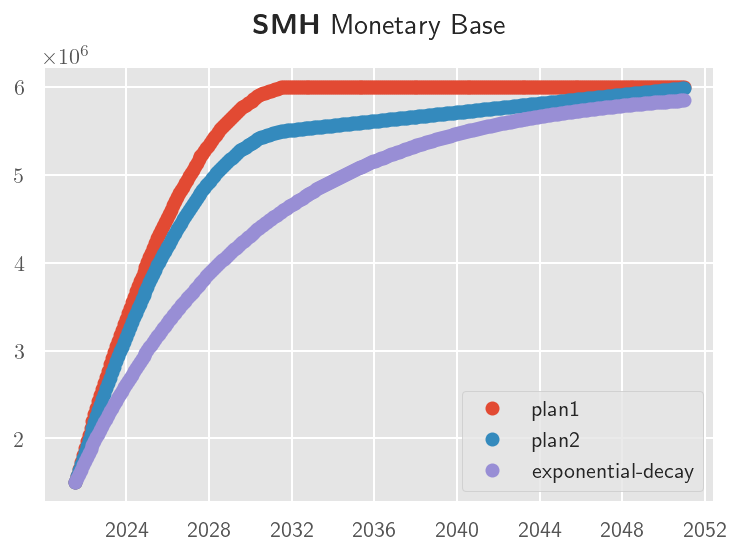

In [52]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve(supply[mask]);

For comparison, you can see the two plans here plotted against an exponential decay function with a six year half-life (similar to what FIL uses). As we can see, these plans are both much more aggressive than FIL (or BTC) issuance: they're faster and steeper.

However, this graph is a little bit misleading since the coins locked up in vaults at genesis haven't vested and aren't liquid. Let's factor that in, and look at how it impacts the exponential decay curve.

In [74]:
def smh_layer_supply_curve_2(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Smeshing rewards,
        # Authorized vault amounts (including unvested),
        # Issued vault amounts (only vested),
    ]

    y_1 = y_2 = y_3 = 0

    for layer in tqdm(range(1, num_layers+1)):
        # 100% of the vaulted amount is authorized as of genesis, so this math is easy
        y_1 = (TOTAL_SUPPLY - VAULTED_AMOUNT) * (1 - (math.exp(-1 * SMH_LAMBDA * layer)))
        
        y_2 = VAULTED_AMOUNT

        # but coins in vaults are not liquid nor spendable at genesis.
        # this math needs to factor in vesting of vaults: 1 year cliff, 4 year total vest
        
        # one year cliff
        y_3 = VAULTED_AMOUNT/5 if layer-1 >= int(LAYERS_PER_YEAR) else 0
        
        # approximate linear vesting after that, from zero up to four more years
        y_3 += max(min((layer-1)/LAYERS_PER_YEAR, 5)-1, 0)*VAULTED_AMOUNT/5
        
        if (layer-1) % output_granularity == 0:
             out.append([layer, y_1, y_2, y_3])

    return out

In [71]:
def datetime_smh_supply_curve_2(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
         layer_supply, columns=['layer', 'smeshing', 'vault1', 'vault2']
    )
    df['smeshing_pct'] = (
        df['smeshing'] / df['smeshing'].values[-1]
        * 100
    )
    df['vault1_pct'] = (
        df['vault1'] / df['vault1'].values[-1]
        * 100
    )
    df['vault2_pct'] = (
        df['vault2'] / df['vault2'].values[-1]
        * 100
    )
    df['total_authorized'] = df['smeshing'] + df['vault1']
    df['total_issued'] = df['smeshing'] + df['vault2']
    df['total_authorized_pct'] = (
        df['total_authorized'] / df['total_authorized'].values[-1]
        * 100
    )
    df['total_issued_pct'] = (
        df['total_issued'] / df['total_issued'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [91]:
def plot_smh_supply_curve_2(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Total - authorized
    if plot_pct:
        values = supply.total_authorized_pct.values[::step_size]
    else:
        values = supply.total_authorized.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-authorized',
    )

    # Total - issued
    if plot_pct:
        values = supply.total_issued_pct.values[::step_size]
    else:
        values = supply.total_issued.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-issued',
    )
    
    # Smeshing
    if plot_pct:
        values = supply.smeshing_pct.values[::step_size]
    else:
        values = supply.smeshing.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='smeshers',
    )
    
    # Vault - authorized (incl. unvested)
    if plot_pct:
        values = supply.vault1_pct.values[::step_size]
    else:
        values = supply.vault1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-all',
    )
    
    # Vault - issued (vested)
    if plot_pct:
        values = supply.vault2_pct.values[::step_size]
    else:
        values = supply.vault2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-vested',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
#     if not out_name:
#         out_name = coin_name
#     plt.savefig(
#         f'../charts/{out_name}.png',
#         bbox_inches='tight',
#         dpi=300
#     )
    return plt

In [119]:
def plot_smh_supply_curve_stackplot(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    import matplotlib.dates as mdates
    
    # date formatting
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Smeshing
    y_1 = supply.smeshing.values[::step_size]
    
    # Vault - issued (vested)
    y_2 = supply.vault2.values[::step_size]
    
    plt.stackplot(dates, y_1, y_2, labels=[
        'smeshing',
        'vault-vested',
    ])
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    ax = plt.gca()
    
#     # format the ticks
    ax.xaxis.set_minor_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.set_minor_locator(months)

#     datemin = datetime.date(pd.DatetimeIndex(supply.date).year[0], 1, 1)
#     datemax = datetime.date(pd.DatetimeIndex(supply.date).year[-1] + 1, 1, 1)
#     ax.set_xlim(datemin, datemax)
    
    return plt

In [75]:
num_layers = int(
    ((end_date - start_date).days * 24 * 3600)
    / layer_time.seconds
)

layer_supply = smh_layer_supply_curve_2(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve_2(
    start_date=start_date,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

In [76]:
display(supply.head())
display(supply.tail())

,layer,smeshing,vault1,vault2,smeshing_pct,vault1_pct,vault2_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,1,4.942012,1500000,0.0,0.000110,100.0,0.0,1.500005e+06,4.942012,25.000102,0.000082,2021-07-01 00:00:00
1,10001,49154.651072,1500000,0.0,1.092327,100.0,0.0,1.549155e+06,49154.651072,25.819264,0.819245,2021-08-04 17:20:00
2,20001,97767.538677,1500000,0.0,2.172614,100.0,0.0,1.597768e+06,97767.538677,26.629480,1.629460,2021-09-08 10:40:00
3,30001,145849.468080,1500000,0.0,3.241103,100.0,0.0,1.645849e+06,145849.468080,27.430846,2.430826,2021-10-13 04:00:00
4,40001,193406.238497,1500000,0.0,4.297921,100.0,0.0,1.693406e+06,193406.238497,28.223459,3.223440,2021-11-16 21:20:00


,layer,smeshing,vault1,vault2,smeshing_pct,vault1_pct,vault2_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
1250,12500001,4.499995e+06,1500000,1500000.0,99.999995,100.0,100.0,5.999995e+06,5.999995e+06,99.999996,99.999996,2140-04-30 18:40:00
1251,12510001,4.499995e+06,1500000,1500000.0,99.999997,100.0,100.0,5.999995e+06,5.999995e+06,99.999997,99.999997,2140-06-04 12:00:00
1252,12520001,4.499995e+06,1500000,1500000.0,99.999998,100.0,100.0,5.999995e+06,5.999995e+06,99.999998,99.999998,2140-07-09 05:20:00
1253,12530001,4.499995e+06,1500000,1500000.0,99.999999,100.0,100.0,5.999995e+06,5.999995e+06,99.999999,99.999999,2140-08-12 22:40:00
1254,12540001,4.499995e+06,1500000,1500000.0,100.000000,100.0,100.0,5.999995e+06,5.999995e+06,100.000000,100.000000,2140-09-16 16:00:00


In [77]:
#plot_smh_supply_curve(supply)

In [78]:
#plot_smh_supply_curve(supply, plot_pct=True)

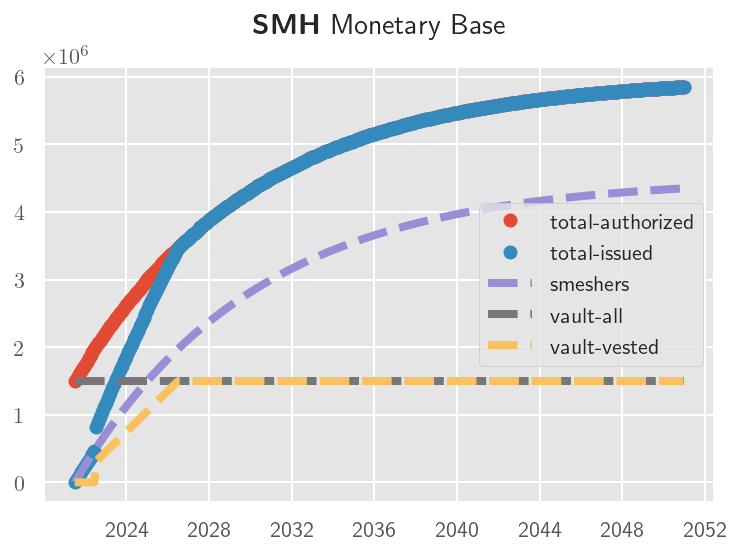

In [92]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve_2(supply[mask])

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

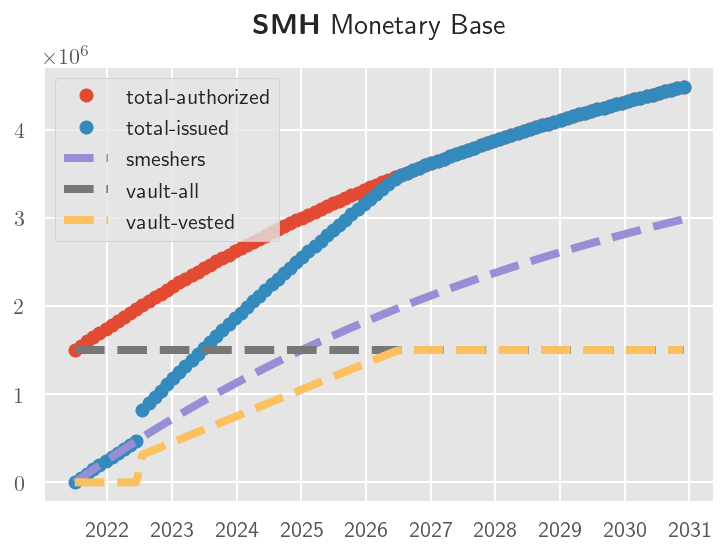

In [105]:
mask = supply.date < datetime.datetime(2031, 1, 1)
plot_smh_supply_curve_2(supply[mask])

The red curve represents the number of coins that have been "authorized," which includes the full portion in vaults reserved for investors and team (in addition to rewards issued to smeshers). The blue curve represents the number of coins that have actually been issued (and are tradeable), including only the _vested_ portion of vaults. The discontinuity in the blue curve represents the end of the one-year vesting cliff.

Here's a stackplot of the breakdown of issuance over time:

<module 'matplotlib.pyplot' from '/home/lane/.local/share/virtualenvs/crypto-monetary-base-xxmj4jsc/lib/python3.8/site-packages/matplotlib/pyplot.py'>

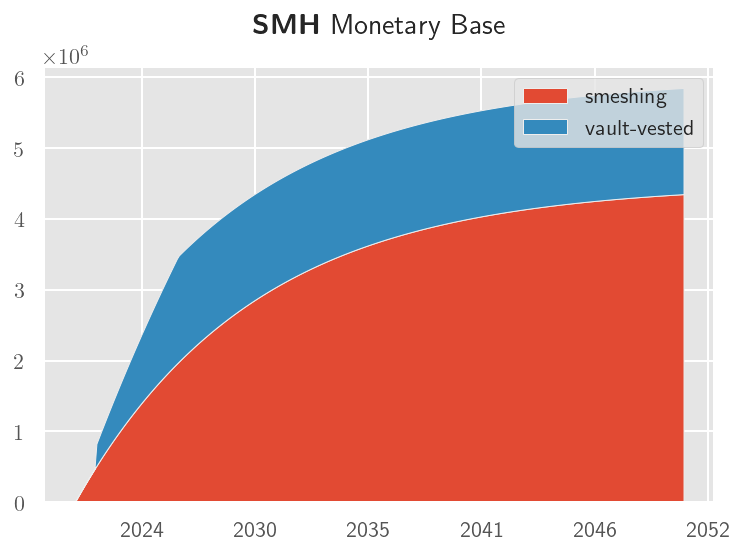

In [120]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve_stackplot(supply[mask])

## One final curve

Putting it all together: including baseline target, vault allocations, vesting, and a hypothetical community fund.

In [74]:
def smh_layer_supply_curve_3(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Smeshing rewards,
        # Authorized vault amounts (including unvested),
        # Issued vault amounts (only vested),
    ]

    y_1 = y_2 = y_3 = 0

    for layer in tqdm(range(1, num_layers+1)):
        # 100% of the vaulted amount is authorized as of genesis, so this math is easy
        y_1 = (TOTAL_SUPPLY - VAULTED_AMOUNT) * (1 - (math.exp(-1 * SMH_LAMBDA * layer)))
        
        y_2 = VAULTED_AMOUNT

        # but coins in vaults are not liquid nor spendable at genesis.
        # this math needs to factor in vesting of vaults: 1 year cliff, 4 year total vest
        
        # one year cliff
        y_3 = VAULTED_AMOUNT/5 if layer-1 >= int(LAYERS_PER_YEAR) else 0
        
        # approximate linear vesting after that, from zero up to four more years
        y_3 += max(min((layer-1)/LAYERS_PER_YEAR, 5)-1, 0)*VAULTED_AMOUNT/5
        
        if (layer-1) % output_granularity == 0:
             out.append([layer, y_1, y_2, y_3])

    return out

In [71]:
def datetime_smh_supply_curve_3(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
         layer_supply, columns=['layer', 'smeshing', 'vault1', 'vault2']
    )
    df['smeshing_pct'] = (
        df['smeshing'] / df['smeshing'].values[-1]
        * 100
    )
    df['vault1_pct'] = (
        df['vault1'] / df['vault1'].values[-1]
        * 100
    )
    df['vault2_pct'] = (
        df['vault2'] / df['vault2'].values[-1]
        * 100
    )
    df['total_authorized'] = df['smeshing'] + df['vault1']
    df['total_issued'] = df['smeshing'] + df['vault2']
    df['total_authorized_pct'] = (
        df['total_authorized'] / df['total_authorized'].values[-1]
        * 100
    )
    df['total_issued_pct'] = (
        df['total_issued'] / df['total_issued'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [91]:
def plot_smh_supply_curve_3(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Total - authorized
    if plot_pct:
        values = supply.total_authorized_pct.values[::step_size]
    else:
        values = supply.total_authorized.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-authorized',
    )

    # Total - issued
    if plot_pct:
        values = supply.total_issued_pct.values[::step_size]
    else:
        values = supply.total_issued.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        label='total-issued',
    )
    
    # Smeshing
    if plot_pct:
        values = supply.smeshing_pct.values[::step_size]
    else:
        values = supply.smeshing.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='smeshers',
    )
    
    # Vault - authorized (incl. unvested)
    if plot_pct:
        values = supply.vault1_pct.values[::step_size]
    else:
        values = supply.vault1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-all',
    )
    
    # Vault - issued (vested)
    if plot_pct:
        values = supply.vault2_pct.values[::step_size]
    else:
        values = supply.vault2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        lw=4,
        fmt='--',
        label='vault-vested',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
#     if not out_name:
#         out_name = coin_name
#     plt.savefig(
#         f'../charts/{out_name}.png',
#         bbox_inches='tight',
#         dpi=300
#     )
    return plt

In [119]:
def plot_smh_supply_curve_stackplot_3(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    import matplotlib.dates as mdates
    
    # date formatting
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Smeshing
    y_1 = supply.smeshing.values[::step_size]
    
    # Vault - issued (vested)
    y_2 = supply.vault2.values[::step_size]
    
    plt.stackplot(dates, y_1, y_2, labels=[
        'smeshing',
        'vault-vested',
    ])
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    ax = plt.gca()
    
#     # format the ticks
    ax.xaxis.set_minor_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
#     ax.xaxis.set_minor_locator(months)

#     datemin = datetime.date(pd.DatetimeIndex(supply.date).year[0], 1, 1)
#     datemax = datetime.date(pd.DatetimeIndex(supply.date).year[-1] + 1, 1, 1)
#     ax.set_xlim(datemin, datemax)
    
    return plt

In [75]:
num_layers = int(
    ((end_date - start_date).days * 24 * 3600)
    / layer_time.seconds
)

layer_supply = smh_layer_supply_curve_2(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve_2(
    start_date=start_date,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

In [76]:
display(supply.head())
display(supply.tail())

,layer,smeshing,vault1,vault2,smeshing_pct,vault1_pct,vault2_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
0,1,4.942012,1500000,0.0,0.000110,100.0,0.0,1.500005e+06,4.942012,25.000102,0.000082,2021-07-01 00:00:00
1,10001,49154.651072,1500000,0.0,1.092327,100.0,0.0,1.549155e+06,49154.651072,25.819264,0.819245,2021-08-04 17:20:00
2,20001,97767.538677,1500000,0.0,2.172614,100.0,0.0,1.597768e+06,97767.538677,26.629480,1.629460,2021-09-08 10:40:00
3,30001,145849.468080,1500000,0.0,3.241103,100.0,0.0,1.645849e+06,145849.468080,27.430846,2.430826,2021-10-13 04:00:00
4,40001,193406.238497,1500000,0.0,4.297921,100.0,0.0,1.693406e+06,193406.238497,28.223459,3.223440,2021-11-16 21:20:00


,layer,smeshing,vault1,vault2,smeshing_pct,vault1_pct,vault2_pct,total_authorized,total_issued,total_authorized_pct,total_issued_pct,date
1250,12500001,4.499995e+06,1500000,1500000.0,99.999995,100.0,100.0,5.999995e+06,5.999995e+06,99.999996,99.999996,2140-04-30 18:40:00
1251,12510001,4.499995e+06,1500000,1500000.0,99.999997,100.0,100.0,5.999995e+06,5.999995e+06,99.999997,99.999997,2140-06-04 12:00:00
1252,12520001,4.499995e+06,1500000,1500000.0,99.999998,100.0,100.0,5.999995e+06,5.999995e+06,99.999998,99.999998,2140-07-09 05:20:00
1253,12530001,4.499995e+06,1500000,1500000.0,99.999999,100.0,100.0,5.999995e+06,5.999995e+06,99.999999,99.999999,2140-08-12 22:40:00
1254,12540001,4.499995e+06,1500000,1500000.0,100.000000,100.0,100.0,5.999995e+06,5.999995e+06,100.000000,100.000000,2140-09-16 16:00:00


In [77]:
#plot_smh_supply_curve(supply)

In [78]:
#plot_smh_supply_curve(supply, plot_pct=True)

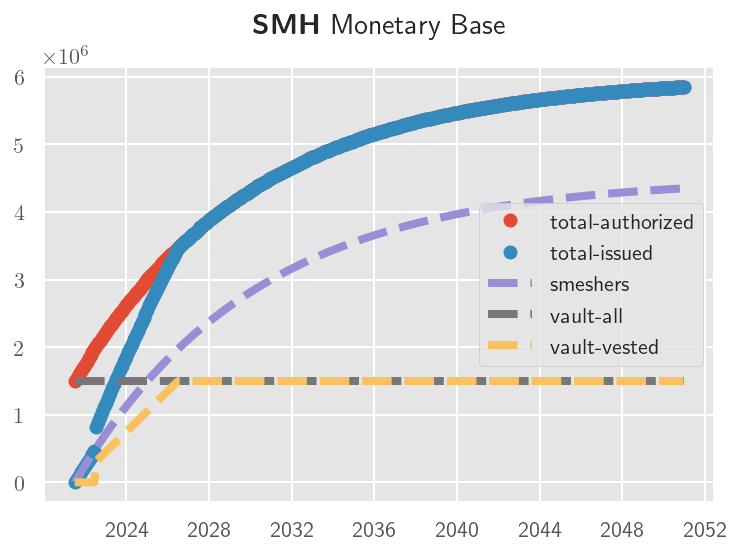

In [92]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve_2(supply[mask])

## Standardize Time Series

In [16]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 1255 lines to file ../output-data/SMH_weekly.csv


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,SMH,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01
1,SMH,10001,1.577788e+06,1.569145e+06,1.503565e+06,26.296460,26.152409,25.183672,2021-08-01
2,SMH,20001,1.655567e+06,1.638282e+06,1.507130e+06,27.592791,27.304703,25.243381,2021-09-01
3,SMH,30001,1.733347e+06,1.707420e+06,1.510695e+06,28.889122,28.456998,25.303091,2021-10-01
4,SMH,40001,1.811127e+06,1.776557e+06,1.514260e+06,30.185453,29.609292,25.362801,2021-11-01


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,SMH,12500001,6.000000e+06,6.000000e+06,5.956138e+06,100.0,100.0,99.761161,2140-04-01
1251,SMH,12510001,6.000000e+06,6.000000e+06,5.959703e+06,100.0,100.0,99.820871,2140-06-01
1252,SMH,12520001,6.000000e+06,6.000000e+06,5.963268e+06,100.0,100.0,99.880580,2140-07-01
1253,SMH,12530001,6.000000e+06,6.000000e+06,5.966832e+06,100.0,100.0,99.940290,2140-08-01
1254,SMH,12540001,6.000000e+06,6.000000e+06,5.970397e+06,100.0,100.0,100.000000,2140-09-01


In [17]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1255 lines to file ../output-data/SMH_monthly.csv


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,SMH,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01
1,SMH,10001,1.577788e+06,1.569145e+06,1.503565e+06,26.296460,26.152409,25.183672,2021-08-01
2,SMH,20001,1.655567e+06,1.638282e+06,1.507130e+06,27.592791,27.304703,25.243381,2021-09-01
3,SMH,30001,1.733347e+06,1.707420e+06,1.510695e+06,28.889122,28.456998,25.303091,2021-10-01
4,SMH,40001,1.811127e+06,1.776557e+06,1.514260e+06,30.185453,29.609292,25.362801,2021-11-01


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,SMH,12500001,6.000000e+06,6.000000e+06,5.956138e+06,100.0,100.0,99.761161,2140-04-01
1251,SMH,12510001,6.000000e+06,6.000000e+06,5.959703e+06,100.0,100.0,99.820871,2140-06-01
1252,SMH,12520001,6.000000e+06,6.000000e+06,5.963268e+06,100.0,100.0,99.880580,2140-07-01
1253,SMH,12530001,6.000000e+06,6.000000e+06,5.966832e+06,100.0,100.0,99.940290,2140-08-01
1254,SMH,12540001,6.000000e+06,6.000000e+06,5.970397e+06,100.0,100.0,100.000000,2140-09-01


In [18]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 120 lines to file ../output-data/SMH_yearly.csv


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,SMH,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01
1,SMH,60001,1.966687e+06,1.914833e+06,1.521390e+06,32.778115,31.913880,25.482220,2022-01-01
2,SMH,160001,2.701855e+06,2.568316e+06,1.557039e+06,45.030917,42.805260,26.079318,2023-01-01
3,SMH,270001,3.425506e+06,3.211561e+06,1.596253e+06,57.091759,53.526008,26.736125,2024-01-01
4,SMH,370001,4.005413e+06,3.727034e+06,1.631902e+06,66.756878,62.117225,27.333223,2025-01-01


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
115,SMH,12050001,6.000000e+06,6.000000e+06,5.795717e+06,100.0,100.0,97.074222,2136-01-01
116,SMH,12150001,6.000000e+06,6.000000e+06,5.831366e+06,100.0,100.0,97.671319,2137-01-01
117,SMH,12260001,6.000000e+06,6.000000e+06,5.870580e+06,100.0,100.0,98.328127,2138-01-01
118,SMH,12370001,6.000000e+06,6.000000e+06,5.909794e+06,100.0,100.0,98.984934,2139-02-01
119,SMH,12470001,6.000000e+06,6.000000e+06,5.945443e+06,100.0,100.0,99.582032,2140-01-01
